In [37]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
)
import numpy as np
from modeling import create_model, create_reg_model, update_config

In [38]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp["year"] = pbp["game_id"].apply(lambda x: int(x.split("_")[0]))
small = pbp.loc[pbp.year > 2021].dropna(how="all", axis=1)
print(pbp.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards',
       'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type',
       'defense_coverage_type', 'year'],
      dtype='object', length=393)


In [39]:
desc_cols = [
    "play_id",
    "game_id",
    "home_team",
    "away_team",
    "game_half",
    "posteam",
    "side_of_field",
    "desc",
]


In [40]:
play_type_mapping = {
    "field_goal": 0,
    "no_play": 1,
    "pass": 2,
    "punt": 3,
    "qb_kneel": 4,
    "qb_spike": 5,
    "run": 6,
    np.nan: 7,
}

In [41]:
game_context_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    # "yards_gained",
    "posteam_score",
    # "total_away_score",
    "score_differential",
    "quarter_seconds_remaining",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "wind",
    "temp",
    "spread_line",
    "total_line",
]

pbp["play_type_enc"] = pbp["play_type"].map(play_type_mapping)
y_col = "play_type_enc"
data = pbp.loc[
    (~pbp.down.isna()) & (~pbp.rush_attempt.isna()) & ~(pbp.play_type.isna())
][game_context_cols + [y_col]]

In [42]:
team_receiver_stats = pd.read_csv("data/team_receiver_stats.csv", index_col=0)
receiver_cols = [x for x in team_receiver_stats.columns if "ception" in x] + [
    x for x in team_receiver_stats.columns if "arget" in x
] + [x for x in team_receiver_stats.columns if "ppr" in x] + [
    x for x in team_receiver_stats.columns if "pct" in x] + [
        x for x in team_receiver_stats.columns if "per_catch" in x
    ]
sorted(receiver_cols)

['fantasy_points_ppr_roll_RB_0',
 'fantasy_points_ppr_roll_RB_1',
 'fantasy_points_ppr_roll_TE_0',
 'fantasy_points_ppr_roll_TE_1',
 'fantasy_points_ppr_roll_TE_2',
 'fantasy_points_ppr_roll_WR_0',
 'fantasy_points_ppr_roll_WR_1',
 'fantasy_points_ppr_roll_WR_2',
 'fantasy_points_ppr_roll_WR_3',
 'fantasy_points_ppr_roll_WR_4',
 'offense_pct_roll_RB_0',
 'offense_pct_roll_RB_1',
 'offense_pct_roll_TE_0',
 'offense_pct_roll_TE_1',
 'offense_pct_roll_TE_2',
 'offense_pct_roll_WR_0',
 'offense_pct_roll_WR_1',
 'offense_pct_roll_WR_2',
 'offense_pct_roll_WR_3',
 'offense_pct_roll_WR_4',
 'receptions_roll_RB_0',
 'receptions_roll_RB_1',
 'receptions_roll_TE_0',
 'receptions_roll_TE_1',
 'receptions_roll_TE_2',
 'receptions_roll_WR_0',
 'receptions_roll_WR_1',
 'receptions_roll_WR_2',
 'receptions_roll_WR_3',
 'receptions_roll_WR_4',
 'target_share_roll_RB_0',
 'target_share_roll_RB_1',
 'target_share_roll_TE_0',
 'target_share_roll_TE_1',
 'target_share_roll_TE_2',
 'target_share_roll_WR_0'

In [43]:
team_rusher_cols = ['carries_roll_QB_0',
 'carries_roll_QB_1',
 'carries_roll_RB_0',
 'carries_roll_RB_1',
 'carries_roll_RB_2',
 'carries_roll_TE_0',
 'carries_roll_WR_0',
 'fantasy_points_ppr_roll_QB_0',
 'fantasy_points_ppr_roll_QB_1',
 'fantasy_points_ppr_roll_RB_0',
 'fantasy_points_ppr_roll_RB_1',
 'fantasy_points_ppr_roll_RB_2',
 'fantasy_points_ppr_roll_TE_0',
 'fantasy_points_ppr_roll_WR_0',
 'yards_per_carry_roll_QB_0',
 'yards_per_carry_roll_QB_1',
 'yards_per_carry_roll_RB_0',
 'yards_per_carry_roll_RB_1',
 'yards_per_carry_roll_RB_2',
 'yards_per_carry_roll_TE_0',
 'yards_per_carry_roll_WR_0',
 'offense_pct_roll_QB_0',
 'offense_pct_roll_QB_1',
 'offense_pct_roll_RB_0',
 'offense_pct_roll_RB_1',
 'offense_pct_roll_RB_2',
 'offense_pct_roll_TE_0',
 'offense_pct_roll_WR_0',
 'rushing_first_downs_roll_QB_0',
 'rushing_first_downs_roll_QB_1',
 'rushing_first_downs_roll_RB_0',
 'rushing_first_downs_roll_RB_1',
 'rushing_first_downs_roll_RB_2',
 'rushing_first_downs_roll_TE_0',
 'rushing_first_downs_roll_WR_0',
 'rushing_tds_roll_QB_0',
 'rushing_tds_roll_QB_1',
 'rushing_tds_roll_RB_0',
 'rushing_tds_roll_RB_1',
 'rushing_tds_roll_RB_2',
 'rushing_tds_roll_TE_0',
 'rushing_tds_roll_WR_0',
 'rushing_yards_roll_QB_0',
 'rushing_yards_roll_QB_1',
 'rushing_yards_roll_RB_0',
 'rushing_yards_roll_RB_1',
 'rushing_yards_roll_RB_2',
 'rushing_yards_roll_TE_0',
 'rushing_yards_roll_WR_0',
 'last_rusher_drive',
 'last_rusher_team']

In [44]:
def get_rusher_number(row):
    """0-2 is RB, 3-7 is WR, 8-10 is TE"""
    for num, col_name in enumerate(
        [
            "gsis_id_RB_0",
            "gsis_id_RB_1",
            "gsis_id_RB_2",
            "gsis_id_QB_0",
            "gsis_id_QB_1",
            "gsis_id_TE_0",
            "gsis_id_WR_0",
        ]
    ):
        if row[col_name] == row["rusher_player_id"]:
            return num
    return None

In [45]:
team_rb_stats = pd.read_csv("data/team_rushers.csv", index_col=0)
comb = pbp.merge(
    team_rb_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team_name", "season", "week"],
)

comb["rusher_depth_num"] = comb.apply(get_rusher_number, axis=1)
rushes = comb.loc[(~comb.rusher_depth_num.isna()) & (~comb.yards_gained.isna())].copy(
    deep=True
)
rushes["last_rusher_drive"] = (
    rushes.groupby(["game_id", "drive", "posteam"])["rusher_depth_num"]
    .shift()
    .fillna(-1)
)
rushes["last_rusher_team"] = (
    rushes.groupby(["game_id", "posteam"])["rusher_depth_num"].shift().fillna(-1)
)
rushes[(game_context_cols + team_rusher_cols)]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,...,rushing_tds_roll_WR_0,rushing_yards_roll_QB_0,rushing_yards_roll_QB_1,rushing_yards_roll_RB_0,rushing_yards_roll_RB_1,rushing_yards_roll_RB_2,rushing_yards_roll_TE_0,rushing_yards_roll_WR_0,last_rusher_drive,last_rusher_team
2,78.0,2.0,0,10.0,0.0,0.0,864.0,1764.0,3564.0,2.981286,...,0.00000,0.000000,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,-1.0,-1.0
5,38.0,1.0,0,10.0,0.0,0.0,772.0,1672.0,3472.0,2.981286,...,0.00000,0.000000,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,0.0,0.0
7,24.0,1.0,0,10.0,0.0,0.0,701.0,1601.0,3401.0,2.981286,...,0.00000,0.000000,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,0.0,0.0
8,22.0,2.0,0,8.0,0.0,0.0,663.0,1563.0,3363.0,2.981286,...,0.00000,0.000000,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,0.0,0.0
10,19.0,1.0,0,10.0,0.0,0.0,626.0,1526.0,3326.0,2.981286,...,0.00000,0.000000,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676547,41.0,3.0,0,7.0,27.0,14.0,329.0,329.0,329.0,5.000000,...,0.00187,1.856886,0.000000,57.549277,25.080053,7.439638,0.000000e+00,5.859835,0.0,0.0
676558,8.0,1.0,1,8.0,13.0,-14.0,143.0,143.0,143.0,5.000000,...,0.00000,31.152196,2.366409,22.929323,66.391682,1.005665,6.268008e-07,1.751297,-1.0,1.0
676564,65.0,2.0,0,5.0,27.0,7.0,128.0,128.0,128.0,5.000000,...,0.00187,1.856886,0.000000,57.549277,25.080053,7.439638,0.000000e+00,5.859835,-1.0,0.0
676566,59.0,1.0,0,10.0,27.0,7.0,75.0,75.0,75.0,5.000000,...,0.00187,1.856886,0.000000,57.549277,25.080053,7.439638,0.000000e+00,5.859835,0.0,0.0


In [46]:
comb.loc[comb.rusher_player_name=='J.Hurts'][['home_team','season','week','rusher_player_id','rusher_depth_num', 'gsis_id_QB_0',
                                              'gsis_id_QB_1','desc']]

,home_team,season,week,rusher_player_id,rusher_depth_num,gsis_id_QB_0,gsis_id_QB_1,desc
462838,PHI,2020,3,00-0036389,NaN,00-0032950,00-0032792,(11:46) (Shotgun) Direct snap to 2-J.Hurts. 2-...
462875,PHI,2020,3,00-0036389,NaN,00-0032950,00-0032792,(11:43) (Shotgun) 2-J.Hurts to PHI 44 for -3 y...
467357,SF,2020,4,00-0036389,4.0,00-0032950,00-0036389,(1:24) #2 J.Hurts in at QB. (Shotgun) 2-J.Hurt...
467409,SF,2020,4,00-0036389,4.0,00-0032950,00-0036389,(9:58) 2-J.Hurts right end ran ob at SF 38 for...
467415,SF,2020,4,00-0036389,4.0,00-0032950,00-0036389,(6:39) (Shotgun) 2-J.Hurts FUMBLES (Aborted) a...
...,...,...,...,...,...,...,...,...
675167,LA,2024,12,00-0036389,3.0,00-0036389,00-0038102,(:17) (Shotgun) 1-J.Hurts up the middle to LA ...
675169,LA,2024,12,00-0036389,3.0,00-0036389,00-0038102,(:07) (Shotgun) 1-J.Hurts left tackle to PHI 4...
675189,LA,2024,12,00-0036389,3.0,00-0036389,00-0038102,(9:16) 1-J.Hurts left guard to LA 44 for 5 yar...
675217,LA,2024,12,00-0036389,3.0,00-0036389,00-0038102,(11:30) (Shotgun) 1-J.Hurts left guard to LA 8...


In [47]:
choose_rusher_cols = (
    game_context_cols + team_rusher_cols
)
choose_rusher_model = create_model(
    rushes, x_cols=choose_rusher_cols, y_col="rusher_depth_num"
)
joblib.dump(choose_rusher_model, "models/choose_rusher.joblib")
_ = """
Accuracy: 0.69
Confusion Matrix:
array([[17449,  1485,   433,   442,    45,     3,     4],
       [ 3336,  5003,   321,   309,    25,     1,     0],
       [ 1227,   518,  1998,   138,    12,     1,     0],
       [ 1857,   630,   241,  2019,    20,     0,     0],
       [  264,    91,    64,    98,   220,     0,     2],
       [   17,     4,     8,     2,     0,     7,     0],
       [  157,    45,    20,     8,     2,     0,     3]], dtype=int64)
"""

Accuracy: 0.70
Confusion Matrix:


array([[17613,  1280,   364,   434,    53,     5,     7],
       [ 3253,  5086,   327,   285,    52,     1,     5],
       [ 1144,   554,  2010,   138,    33,     0,     2],
       [ 1814,   635,   252,  2124,    13,     1,     2],
       [  286,    87,    61,    13,   334,     0,     1],
       [   17,     4,     7,     4,     0,     6,     0],
       [  162,    53,    23,     7,     0,     0,     5]], dtype=int64)

In [48]:
rusher_idx_to_pos = {
    idx: col_name.split("id_")[-1]
    for idx, col_name in enumerate(
        [
            "gsis_id_RB_0",
            "gsis_id_RB_1",
            "gsis_id_RB_2",
            "gsis_id_QB_0",
            "gsis_id_QB_1",
            "gsis_id_TE_0",
            "gsis_id_WR_0",
        ]
    )
}
rusher_idx_to_pos

{0: 'RB_0', 1: 'RB_1', 2: 'RB_2', 3: 'QB_0', 4: 'QB_1', 5: 'TE_0', 6: 'WR_0'}

In [49]:
feature_config = {
    "choose_rusher_cols": choose_rusher_cols,
    'rusher_idx_to_pos': rusher_idx_to_pos
}
feature_config


{'choose_rusher_cols': ['yardline_100',
  'down',
  'goal_to_go',
  'ydstogo',
  'posteam_score',
  'score_differential',
  'quarter_seconds_remaining',
  'half_seconds_remaining',
  'game_seconds_remaining',
  'wind',
  'temp',
  'spread_line',
  'total_line',
  'carries_roll_QB_0',
  'carries_roll_QB_1',
  'carries_roll_RB_0',
  'carries_roll_RB_1',
  'carries_roll_RB_2',
  'carries_roll_TE_0',
  'carries_roll_WR_0',
  'fantasy_points_ppr_roll_QB_0',
  'fantasy_points_ppr_roll_QB_1',
  'fantasy_points_ppr_roll_RB_0',
  'fantasy_points_ppr_roll_RB_1',
  'fantasy_points_ppr_roll_RB_2',
  'fantasy_points_ppr_roll_TE_0',
  'fantasy_points_ppr_roll_WR_0',
  'yards_per_carry_roll_QB_0',
  'yards_per_carry_roll_QB_1',
  'yards_per_carry_roll_RB_0',
  'yards_per_carry_roll_RB_1',
  'yards_per_carry_roll_RB_2',
  'yards_per_carry_roll_TE_0',
  'yards_per_carry_roll_WR_0',
  'offense_pct_roll_QB_0',
  'offense_pct_roll_QB_1',
  'offense_pct_roll_RB_0',
  'offense_pct_roll_RB_1',
  'offense_pct

In [50]:
update_config(feature_config)

In [51]:
passes = pbp.loc[(~pbp.receiver_player_id.isna()) & (pbp.play_type_enc == 2)].copy(
    deep=True
)
passes = passes.merge(
    team_receiver_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team_name", "season", "week"],
)
passes.sample(3)


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,fantasy_points_ppr_roll_RB_1,fantasy_points_ppr_roll_RB_0,offense_snaps_roll_RB_1,offense_snaps_roll_RB_0,offense_pct_roll_RB_1,offense_pct_roll_RB_0,yards_per_catch_roll_RB_1,yards_per_catch_roll_RB_0,yards_per_target_roll_RB_1,yards_per_target_roll_RB_0
99958,4631.0,2015_08_CIN_PIT,2015110102,PIT,CIN,REG,8,PIT,home,CIN,...,4.021379,18.813223,12.767181,53.412324,0.212052,0.894401,5.415608,7.993591,3.627797,6.746883
232905,3246.0,2022_10_IND_LV,None,LV,IND,REG,10,IND,away,LV,...,5.619101,10.799232,21.158034,43.966783,0.305717,0.698335,7.415971,4.242203,6.541897,2.883332
172113,1565.0,2019_05_GB_DAL,None,DAL,GB,REG,5,GB,away,DAL,...,7.585940,15.941628,25.896607,40.888017,0.399946,0.596489,7.247193,6.547302,6.136681,5.328754


In [52]:
def get_receiver_number(row):
    """0-2 is RB, 3-7 is WR, 8-10 is TE"""
    for num, col_name in enumerate(
        [
            "gsis_id_WR_0",
            "gsis_id_WR_1",
            "gsis_id_WR_2",
            "gsis_id_WR_3",
            "gsis_id_WR_4",
            "gsis_id_TE_0",
            "gsis_id_TE_1",
            "gsis_id_TE_2",
            "gsis_id_RB_0",
            "gsis_id_RB_1",
        ]
    ):
        if row[col_name] == row["receiver_player_id"]:
            return num
    return None


In [53]:
receiver_idx_to_pos = {
    idx: col_name.split("id_")[-1]
    for idx, col_name in enumerate(
        [
            "gsis_id_WR_0",
            "gsis_id_WR_1",
            "gsis_id_WR_2",
            "gsis_id_WR_3",
            "gsis_id_WR_4",
            "gsis_id_TE_0",
            "gsis_id_TE_1",
            "gsis_id_TE_2",
            "gsis_id_RB_0",
            "gsis_id_RB_1",
        ]
    )
}
receiver_idx_to_pos


{0: 'WR_0',
 1: 'WR_1',
 2: 'WR_2',
 3: 'WR_3',
 4: 'WR_4',
 5: 'TE_0',
 6: 'TE_1',
 7: 'TE_2',
 8: 'RB_0',
 9: 'RB_1'}

In [54]:
passes["receiver_idx"] = passes.apply(get_receiver_number, axis=1)
passes[
    [
        "posteam",
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
        "receiver_player_id",
        "receiver_idx",
    ]
]


,posteam,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1,receiver_player_id,receiver_idx
0,ARI,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0023108,6.0
1,ARI,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0022921,0.0
2,ARI,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0026289,8.0
3,ARI,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0025529,1.0
4,LA,00-0025462,00-0026035,00-0026937,00-0023457,00-0027700,00-0023679,00-0023752,00-0027732,00-0022736,00-0025633,00-0023457,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272570,NYG,00-0035535,00-0038117,00-0039337,00-0038938,00-0038477,00-0038115,00-0039847,00-0031484,00-0035250,00-0039384,00-0039384,9.0
272571,NYG,00-0035535,00-0038117,00-0039337,00-0038938,00-0038477,00-0038115,00-0039847,00-0031484,00-0035250,00-0039384,00-0039847,6.0
272572,NYG,00-0035535,00-0038117,00-0039337,00-0038938,00-0038477,00-0038115,00-0039847,00-0031484,00-0035250,00-0039384,00-0039337,2.0
272573,DAL,00-0036358,00-0037801,00-0037666,00-0038640,00-0039410,00-0038041,00-0038547,00-0039530,00-0036139,00-0033045,00-0038640,3.0


In [55]:
team_receiver_stats[
    [
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
    ]
]


,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1
0,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
1,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
2,00-0022921,00-0025529,00-0027349,00-0027691,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0022288
3,00-0025529,00-0022921,00-0026221,00-0027349,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
4,00-0022921,00-0025529,00-0027349,00-0026221,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
...,...,...,...,...,...,...,...,...,...,...
8929,00-0035659,00-0039355,00-0035208,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699
8930,00-0035659,00-0039355,00-0035208,00-0033591,00-0036626,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699
8931,00-0035208,00-0035659,00-0039355,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699
8932,00-0035659,00-0039355,00-0035208,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699


In [56]:
choose_receiver_cols = game_context_cols + receiver_cols
choose_receiver_model = create_model(
    passes, x_cols=choose_receiver_cols, y_col="receiver_idx", colsample_bytree=0.6
)
joblib.dump(choose_receiver_model, "models/choose_receiver.joblib")
#0.26
_ = '''
array([[4621, 2668,  719,  239,  101,  980,  172,   67,  248,  151],
       [2879, 4241,  792,  264,   95,  888,  201,   58,  231,  149],
       [1544, 1506, 1167,  150,   83,  577,  106,   25,  146,   80],
       [1168, 1020,  231,  351,   49,  443,   96,   35,  112,   76],
       [ 495,  432,  172,   55,  168,  214,   29,   11,   55,   36],
       [2133, 1924,  528,  206,   81, 1390,   76,   28,  186,  114],
       [1037,  975,  239,   86,   51,  270,  237,   13,   82,   69],
       [ 347,  354,  101,   38,   15,  119,   43,   58,   30,   25],
       [1605, 1499,  397,  124,   55,  472,  110,   32,  339,   43],
       [ 945,  874,  308,  126,   35,  386,   67,   28,   57,  232]],
      dtype=int64)
      '''

Accuracy: 0.26
Confusion Matrix:


array([[4671, 2683,  724,  277,   83,  921,  173,   61,  258,  157],
       [2877, 4186,  713,  242,   98,  915,  193,   61,  222,  147],
       [1635, 1563, 1135,  153,   70,  581,  115,   29,  148,  113],
       [1189, 1030,  221,  341,   50,  408,   71,   22,  135,   69],
       [ 477,  427,  159,   65,  157,  229,   45,   14,   59,   32],
       [2190, 2029,  555,  206,   72, 1388,   83,   35,  172,  121],
       [ 988,  982,  264,   85,   41,  263,  250,   23,   93,   69],
       [ 403,  348,   81,   36,   14,  112,   32,   75,   33,   24],
       [1580, 1444,  347,  143,   62,  459,  108,   34,  347,   41],
       [ 962,  904,  235,  105,   47,  364,   94,   15,   65,  210]],
      dtype=int64)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

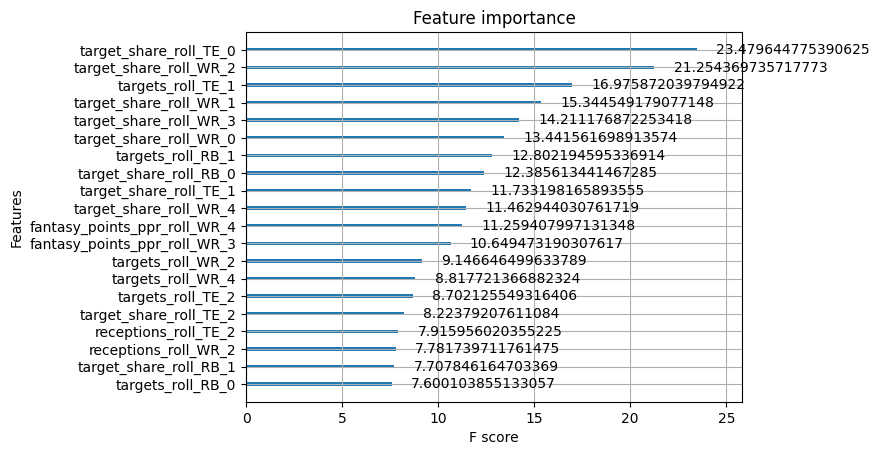

In [57]:
xgb.plot_importance(choose_receiver_model, importance_type="gain", max_num_features=20)

In [58]:
feature_config = {}
feature_config["receiver_idx_to_pos"] =  receiver_idx_to_pos
feature_config['choose_receiver_cols'] = choose_receiver_cols


In [59]:
feature_config.keys()

dict_keys(['receiver_idx_to_pos', 'choose_receiver_cols'])

In [60]:
update_config(feature_config)

In [61]:
player_context = [
        "season",
    "team_name",
    "week",
    "game_type",
    "gsis_id",
    "position",
    "depth_position",
    "full_name",
    "season_type",
]

In [62]:
receiver_cols = [
    "dense_depth",
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_catch_roll',
 'yards_per_target_roll',
 'passing_first_downs_roll',
 'offense_pct_roll']

receiver_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet', columns=receiver_cols+player_context)
receiver_stats

,dense_depth,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_ppr_roll,yards_per_catch_roll,yards_per_target_roll,passing_first_downs_roll,offense_pct_roll,season,team_name,week,game_type,gsis_id,position,depth_position,full_name,season_type
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,PIT,1.0,REG,00-0000045,T,RT,Flozell Adams,None
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,PIT,1.0,REG,00-0000865,QB,QB,Charlie Batch,None
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,BAL,1.0,REG,00-0001263,C,C,Matt Birk,None
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,NYJ,1.0,REG,00-0002110,QB,QB,Mark Brunell,None
5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,CHI,1.0,REG,00-0003035,TE,HB,Desmond Clark,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232316,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,SF,13.0,REG,00-0039916,WR,WR,Ricky Pearsall,None
232317,0.0,0.000000,0.000000,0.000000,0.00000,16.791299,NaN,NaN,10.793038,0.996084,2024,CHI,13.0,REG,00-0039918,QB,QB,Caleb Williams,None
232318,1.0,4.393564,7.827360,49.980116,0.02065,9.632735,11.375758,6.385310,0.000000,0.814937,2024,CHI,13.0,REG,00-0039919,WR,WR,Rome Odunze,None
232319,1.0,0.550344,0.550344,7.445829,0.00000,4.917460,13.529416,13.529416,0.000000,0.182205,2024,ARI,13.0,REG,00-0039921,RB,RB,Trey Benson,None


In [63]:
qb_cols = [
    'dense_depth',
    "passing_yards_roll",
    "fantasy_points_ppr_roll",
    "sacks_roll",
    "passing_yards_after_catch_roll",
    "interceptions_roll",
    "passing_tds_roll",
    "offense_pct_roll",
    "passing_air_yards_roll",
    "receiving_air_yards_roll",
    "passing_first_downs_roll",
    "sack_yards_roll",
    "completion_pct_roll"
]
qb_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet', columns=qb_cols+player_context)
qb_stats.loc[qb_stats.full_name == 'Patrick Mahomes']

,dense_depth,passing_yards_roll,fantasy_points_ppr_roll,sacks_roll,passing_yards_after_catch_roll,interceptions_roll,passing_tds_roll,offense_pct_roll,passing_air_yards_roll,receiving_air_yards_roll,...,completion_pct_roll,season,team_name,week,game_type,gsis_id,position,depth_position,full_name,season_type
110859,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017,KC,1.0,REG,00-0033873,QB,QB,Patrick Mahomes,None
111693,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017,KC,2.0,REG,00-0033873,QB,QB,Patrick Mahomes,None
112514,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017,KC,3.0,REG,00-0033873,QB,QB,Patrick Mahomes,None
113334,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017,KC,4.0,REG,00-0033873,QB,QB,Patrick Mahomes,None
114158,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017,KC,5.0,REG,00-0033873,QB,QB,Patrick Mahomes,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228686,0.0,237.257040,15.253505,1.620490,131.891372,1.230309,1.113919,0.999977,211.992283,-0.040283,...,0.681163,2024,KC,9.0,REG,00-0033873,QB,QB,Patrick Mahomes,REG
229482,0.0,252.663945,17.915735,2.302642,134.789289,0.877607,1.654616,0.999984,230.341863,-0.028735,...,0.712619,2024,KC,10.0,REG,00-0033873,QB,QB,Patrick Mahomes,REG
230259,0.0,256.351830,17.535297,2.772021,149.503912,0.634918,1.473592,0.999988,225.546231,-0.020789,...,0.698640,2024,KC,11.0,REG,00-0033873,QB,QB,Patrick Mahomes,REG
231036,0.0,240.093844,17.078606,2.564049,137.515145,1.002653,1.884786,0.999991,226.207244,-0.015188,...,0.698236,2024,KC,12.0,REG,00-0033873,QB,QB,Patrick Mahomes,REG


In [64]:
qb_stats.columns = [x + '_qb'  if x in qb_cols else x for x in qb_stats.columns]
qb_cols = [x + '_qb' for x in qb_cols]

In [65]:
passes = pbp.loc[(~pbp.receiver_player_id.isna()) & (pbp.play_type_enc == 2)].copy(
    deep=True
)
passes = passes.merge(
    qb_stats,
    left_on=["posteam", "season", "week", "passer_player_id"],
    right_on=["team_name", "season", "week", 'gsis_id'],
)
passes = passes.merge(
    receiver_stats,
    left_on=["posteam", "season", "week", "receiver_player_id"],
    right_on=["team_name", "season", "week", 'gsis_id'],
    suffixes=('_qb','')
)
passes

,play_id,game_id,old_game_id,home_team,away_team,season_type_x,week,posteam,posteam_type,defteam,...,yards_per_target_roll,passing_first_downs_roll,offense_pct_roll,team_name,game_type,gsis_id,position,depth_position,full_name,season_type
0,58.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,ARI,REG,00-0023108,TE,TE,Stephen Spach,REG
1,103.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,ARI,REG,00-0022921,WR,WR,Larry Fitzgerald,REG
2,132.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,ARI,REG,00-0026289,RB,RB,Tim Hightower,REG
3,177.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,ARI,REG,00-0025529,WR,WR,Steve Breaston,REG
4,254.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,LA,home,ARI,...,NaN,NaN,NaN,LA,REG,00-0023457,WR,WR,Mark Clayton,REG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272334,4380.0,2024_13_NYG_DAL,2024112801,DAL,NYG,REG,13,NYG,away,DAL,...,7.162312,0.0,0.833033,NYG,REG,00-0039847,TE,TE,Theo Johnson,None
272335,4405.0,2024_13_NYG_DAL,2024112801,DAL,NYG,REG,13,NYG,away,DAL,...,5.293138,0.0,0.577710,NYG,REG,00-0039384,RB,RB,Tyrone Tracy,None
272336,4466.0,2024_13_NYG_DAL,2024112801,DAL,NYG,REG,13,NYG,away,DAL,...,7.162312,0.0,0.833033,NYG,REG,00-0039847,TE,TE,Theo Johnson,None
272337,4496.0,2024_13_NYG_DAL,2024112801,DAL,NYG,REG,13,NYG,away,DAL,...,6.089096,0.0,0.926796,NYG,REG,00-0039337,WR,WR,Malik Nabers,None


In [66]:
completion_features = game_context_cols + qb_cols + receiver_cols + ['air_yards']
completion_features

['yardline_100',
 'down',
 'goal_to_go',
 'ydstogo',
 'posteam_score',
 'score_differential',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'wind',
 'temp',
 'spread_line',
 'total_line',
 'dense_depth_qb',
 'passing_yards_roll_qb',
 'fantasy_points_ppr_roll_qb',
 'sacks_roll_qb',
 'passing_yards_after_catch_roll_qb',
 'interceptions_roll_qb',
 'passing_tds_roll_qb',
 'offense_pct_roll_qb',
 'passing_air_yards_roll_qb',
 'receiving_air_yards_roll_qb',
 'passing_first_downs_roll_qb',
 'sack_yards_roll_qb',
 'completion_pct_roll_qb',
 'dense_depth',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_catch_roll',
 'yards_per_target_roll',
 'passing_first_downs_roll',
 'offense_pct_roll',
 'air_yards']

In [67]:
passes[completion_features]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,...,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_ppr_roll,yards_per_catch_roll,yards_per_target_roll,passing_first_downs_roll,offense_pct_roll,air_yards
0,78.0,1.0,0,10.0,0.0,0.0,895.0,1795.0,3595.0,2.981286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,73.0,3.0,0,5.0,0.0,0.0,823.0,1723.0,3523.0,2.981286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2,55.0,1.0,0,10.0,0.0,0.0,797.0,1697.0,3497.0,2.981286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,36.0,2.0,0,8.0,0.0,0.0,727.0,1627.0,3427.0,2.981286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
4,32.0,1.0,0,10.0,0.0,0.0,650.0,1550.0,3350.0,2.981286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272334,57.0,2.0,0,10.0,13.0,-14.0,236.0,236.0,236.0,5.000000,...,2.844314,4.760210,34.094106,0.135074,7.064167,11.986758,7.162312,0.0,0.833033,4.0
272335,45.0,1.0,0,10.0,13.0,-14.0,204.0,204.0,204.0,5.000000,...,2.504719,2.855906,15.116704,0.000000,11.685338,6.035290,5.293138,0.0,0.577710,1.0
272336,37.0,1.0,0,20.0,13.0,-14.0,159.0,159.0,159.0,5.000000,...,2.844314,4.760210,34.094106,0.135074,7.064167,11.986758,7.162312,0.0,0.833033,2.0
272337,24.0,2.0,0,7.0,13.0,-14.0,149.0,149.0,149.0,5.000000,...,6.725964,10.309770,62.777177,0.073434,13.400713,9.333559,6.089096,0.0,0.926796,16.0


In [68]:
def create_model(df, x_cols, y_col, colsample_bytree=0.5):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = xgb.XGBClassifier(eval_metric="mlogloss", colsample_bytree=colsample_bytree)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    display(cm)
    return model

In [69]:
completion_df = passes.loc[~passes.offense_pct_roll.isna()].copy()[completion_features + ['complete_pass']]#.dropna()
#231174

In [70]:
complete_pass_model = create_model(
    completion_df, x_cols=completion_features, y_col="complete_pass", colsample_bytree=0.6
)
joblib.dump(complete_pass_model, "models/complete_pass.joblib")

Accuracy: 0.70
Confusion Matrix:


array([[ 5544, 10520],
       [ 3300, 26466]], dtype=int64)

['models/complete_pass.joblib']

In [71]:
feature_config = {
    "complete_pass_cols": completion_features,
}
feature_config

update_config(feature_config)

In [72]:
passes.loc[passes.air_yards > 40]['complete_pass'].value_counts(normalize=True)

complete_pass
0.0    0.719628
1.0    0.280372
Name: proportion, dtype: float64